In [17]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling2D, Concatenate,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast
)
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

HAS_RUN = False
if HAS_RUN:
    raise RuntimeError("Training already ran. Restart kernel to rerun.")
HAS_RUN = True

TRAIN_CSV = r"C:\Users\ASUS\Documents\project_1\train_with_images.csv"

IMG_SIZE = 224
BATCH = 32
SEED = 42
EPOCHS_PHASE1 = 15
EPOCHS_PHASE2 = 8

tf.random.set_seed(SEED)
np.random.seed(SEED)

train_df = pd.read_csv(TRAIN_CSV)

y = train_df["price_log"].values.astype(np.float32)
y = np.nan_to_num(y, nan=np.nanmean(y))
y_mean, y_std = y.mean(), y.std()


# ---- Spatial features (added ONCE) ----
center_lat  = train_df["lat"].mean()
center_long = train_df["long"].mean()

train_df["dist_from_center"] = np.sqrt(
    (train_df["lat"] - center_lat) ** 2 +
    (train_df["long"] - center_long) ** 2
)

train_df["lat_sin"]  = np.sin(train_df["lat"])
train_df["lat_cos"]  = np.cos(train_df["lat"])
train_df["long_sin"] = np.sin(train_df["long"])
train_df["long_cos"] = np.cos(train_df["long"])

# ---- Feature selection (NO scaling here) ----
drop_cols = ["price", "price_log", "id", "image_path"]
feature_cols = [c for c in train_df.columns if c not in drop_cols]

X_tab = train_df[feature_cols].values.astype(np.float32)
X_tab = np.nan_to_num(X_tab, nan=0.0)
X_tab = np.clip(X_tab, -5, 5)

train_idx, val_idx = train_test_split(
    np.arange(len(train_df)),
    test_size=0.2,
    random_state=SEED,
    stratify=pd.qcut(y, q=10, duplicates="drop")
)

X_tab_train = X_tab[train_idx]
X_tab_val   = X_tab[val_idx]

y_train = y[train_idx]
y_val   = y[val_idx]

train_paths = train_df.iloc[train_idx]["image_path"].values
val_paths   = train_df.iloc[val_idx]["image_path"].values

# IMAGE PIPELINE

augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.15),
        RandomContrast(0.1),
    ],
    name="augmentation"
)

def process_image(path, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    if augment:
        img = augmentation(img)
    img = preprocess_input(img)
    return img

def make_ds(paths, tab, labels, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, tab, labels))
    if shuffle:
        ds = ds.shuffle(len(paths), seed=SEED, reshuffle_each_iteration=True)

    def mapper(p, t, y):
        return (process_image(p, augment), t), y

    ds = ds.map(mapper, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_paths, X_tab_train, y_train, shuffle=True, augment=True)
val_ds   = make_ds(val_paths,   X_tab_val,   y_val,   shuffle=False, augment=False)

# MODEL (MULTIMODAL)


img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")
tab_input = Input(shape=(X_tab_train.shape[1],), name="tabular_input")

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_tensor=img_input
)
base_model.trainable = False

# ---- Image branch ----
x_img = GlobalAveragePooling2D()(base_model.output)
x_img = Dense(512, activation="relu")(x_img)
x_img = BatchNormalization()(x_img)
x_img = Dropout(0.5)(x_img)
x_img = Dense(256, activation="relu")(x_img)

# ---- Tabular branch ----
x_tab = Dense(512, activation="relu")(tab_input)
x_tab = BatchNormalization()(x_tab)
x_tab = Dropout(0.4)(x_tab)
x_tab = Dense(256, activation="relu")(x_tab)

# ---- Fusion ----
x = Concatenate()([x_img, x_tab])
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)

output = Dense(
    1,
    bias_initializer=tf.keras.initializers.Constant(y_mean)
)(x)

model = Model([img_input, tab_input], output)

# PHASE 1 — TRAIN HEAD


model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),
    loss=Huber(),
    metrics=["mae"]
)

callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=4, factor=0.5)
]

print("\n===== PHASE 1: TRAINING HEAD =====")
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks,
    verbose=1
)

# PHASE 2 — FINE TUNING


print("\n===== PHASE 2: FINE TUNING =====")

base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-5),
    loss=Huber(),
    metrics=["mae"]
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks,
    verbose=1
)


# FINAL METRICS


val_preds = model.predict(val_ds).ravel()
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
r2 = r2_score(y_val, val_preds)

print("\n================ FINAL METRICS ================")
print(f"Log RMSE : {rmse:.4f}")
print(f"Log R²   : {r2:.4f}")
print("==============================================")



===== PHASE 1: TRAINING HEAD =====
Epoch 1/15
406/406 ━━━━━━━━━━━━━━━━━━━━ 163s 377ms/step - loss: 0.2257 - mae: 0.5420 - val_loss: 0.0686 - val_mae: 0.2930 - learning_rate: 5.0000e-04
Epoch 2/15
406/406 ━━━━━━━━━━━━━━━━━━━━ 143s 352ms/step - loss: 0.1140 - mae: 0.3765 - val_loss: 0.0551 - val_mae: 0.2578 - learning_rate: 5.0000e-04
Epoch 3/15
406/406 ━━━━━━━━━━━━━━━━━━━━ 146s 360ms/step - loss: 0.0772 - mae: 0.3071 - val_loss: 0.0412 - val_mae: 0.2213 - learning_rate: 5.0000e-04
Epoch 4/15
406/406 ━━━━━━━━━━━━━━━━━━━━ 147s 363ms/step - loss: 0.0582 - mae: 0.2657 - val_loss: 0.0362 - val_mae: 0.2042 - learning_rate: 5.0000e-04
Epoch 5/15
406/406 ━━━━━━━━━━━━━━━━━━━━ 149s 366ms/step - loss: 0.0492 - mae: 0.2433 - val_loss: 0.0293 - val_mae: 0.1836 - learning_rate: 5.0000e-04
Epoch 6/15
406/406 ━━━━━━━━━━━━━━━━━━━━ 146s 360ms/step - loss: 0.0417 - mae: 0.2242 - val_loss: 0.0292 - val_mae: 0.1856 - learning_rate: 5.0000e-04
Epoch 7/15
406/406 ━━━━━━━━━━━━━━━━━━━━ 142s 348ms/step - loss: 

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib

# PATHS

TEST_CSV   = r"C:\Users\ASUS\Documents\project_1\test_with_images.csv"
OUT_CSV    = r"C:\Users\ASUS\Documents\project_1\submission.csv"
SCALER_PKL = r"ml_data.pkl"

IMG_SIZE = 224
BATCH = 32

# LOAD TEST DATA

test_df = pd.read_csv(TEST_CSV)

# LOAD EDA SCALER


eda = joblib.load(SCALER_PKL)
scaler = eda["scaler"]

scaled_cols = list(scaler.feature_names_in_)

# APPLY EDA SCALER


X_scaled = scaler.transform(
    test_df[scaled_cols].astype(np.float32)
)

X_scaled = np.nan_to_num(X_scaled, nan=0.0)
X_scaled = np.clip(X_scaled, -5, 5)

X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=scaled_cols,
    index=test_df.index
)

# RESTORE lat & long


X_scaled_df["lat"]  = test_df["lat"].values
X_scaled_df["long"] = test_df["long"].values

# SPATIAL FEATURES (SAME AS TRAIN)


X_scaled_df["dist_from_center"] = np.sqrt(
    (test_df["lat"] - center_lat) ** 2 +
    (test_df["long"] - center_long) ** 2
)

X_scaled_df["lat_sin"]  = np.sin(test_df["lat"])
X_scaled_df["lat_cos"]  = np.cos(test_df["lat"])
X_scaled_df["long_sin"] = np.sin(test_df["long"])
X_scaled_df["long_cos"] = np.cos(test_df["long"])

# FINAL TABULAR FEATURES (MATCH TRAIN)


drop_cols = ["price", "price_log", "id", "image_path"]
feature_cols = [c for c in train_df.columns if c not in drop_cols]

X_tab_test = X_scaled_df[feature_cols].values.astype(np.float32)
X_tab_test = np.nan_to_num(X_tab_test, nan=0.0)
X_tab_test = np.clip(X_tab_test, -5, 5)

# LOAD ALL IMAGES INTO MEMORY (SAFE & SIMPLE)


def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img.numpy()

print(" Loading test images...")
X_img_test = np.stack([load_image(p) for p in test_df["image_path"].values])

# PREDICT (CORRECT WAY FOR MULTI-INPUT MODEL)


log_preds = model.predict(
    [X_img_test, X_tab_test],
    batch_size=BATCH,
    verbose=1
).ravel()

price_preds = np.expm1(log_preds)

# SAVE SUBMISSION
submission = pd.DataFrame({
    "id": test_df["id"],
    "prediction": price_preds
})

submission.to_csv(OUT_CSV, index=False)
print(" Submission saved at:", OUT_CSV)


🔄 Loading test images...
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 291ms/step
✅ Submission saved at: C:\Users\ASUS\Documents\project_1\submission.csv


C:\Users\ASUS\anaconda3\envs\test1\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


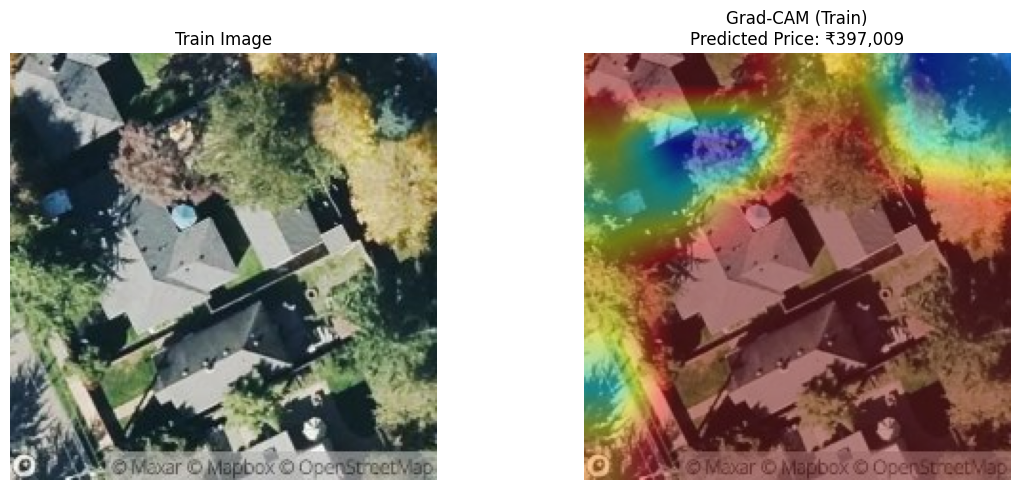

In [23]:
# GRAD-CAM FOR TRAIN_WITH_IMAGES (FINAL)

import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib

from tensorflow.keras.applications.efficientnet import preprocess_input

# CONFIG


EDA_PKL = r"ml_data.pkl"

IMG_SIZE = 224
LAST_CONV_LAYER = "top_conv"   
ROW_INDEX = 0                  #  CHANGE THIS TO ANY TRAIN ROW
ALPHA = 0.4

# LOAD EDA SCALER

eda = joblib.load(EDA_PKL)
scaler = eda["scaler"]
scaled_cols = list(scaler.feature_names_in_)

# ---------------------------------------------------------
# PICK ONE TRAINING ROW
# ---------------------------------------------------------
row = train_df.iloc[ROW_INDEX].copy()

# TABULAR PREPROCESSING (MATCH TRAINING EXACTLY)


# 1️ Apply EDA scaler (same columns as EDA)
X_scaled = scaler.transform(
    row[scaled_cols].values.astype(np.float32).reshape(1, -1)
)
X_scaled = np.clip(X_scaled, -5, 5)
X_scaled = np.nan_to_num(X_scaled, nan=0.0)

X_tab = pd.DataFrame(X_scaled, columns=scaled_cols)

# 2️ Restore lat & long
X_tab["lat"]  = row["lat"]
X_tab["long"] = row["long"]

# 3️ Spatial features (EXACT same as training)
X_tab["dist_from_center"] = np.sqrt(
    (row["lat"] - center_lat) ** 2 +
    (row["long"] - center_long) ** 2
)

X_tab["lat_sin"]  = np.sin(row["lat"])
X_tab["lat_cos"]  = np.cos(row["lat"])
X_tab["long_sin"] = np.sin(row["long"])
X_tab["long_cos"] = np.cos(row["long"])

# 4️⃣ Final feature order (same as model input)
drop_cols = ["price", "price_log", "id", "image_path"]
feature_cols = [c for c in train_df.columns if c not in drop_cols]

tabular_data = X_tab[feature_cols].values.astype(np.float32)

# LOAD IMAGE (TRAIN IMAGE)


img_path = row["image_path"]

img_original = cv2.imread(img_path)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

img = tf.keras.preprocessing.image.load_img(
    img_path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# BUILD GRAD-CAM MODEL


grad_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=[
        model.get_layer(LAST_CONV_LAYER).output,
        model.output
    ]
)

# COMPUTE GRAD-CAM


with tf.GradientTape() as tape:
    conv_outputs, preds = grad_model([img_array, tabular_data])
    target = preds[0, 0]   # log-price

grads = tape.gradient(target, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
heatmap = tf.nn.relu(heatmap)
heatmap /= tf.reduce_max(heatmap) + 1e-8

pred_price = np.expm1(target.numpy())

# VISUALIZATION


heatmap = cv2.resize(heatmap.numpy(), (IMG_SIZE, IMG_SIZE))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

overlay = cv2.addWeighted(
    cv2.resize(img_original, (IMG_SIZE, IMG_SIZE)),
    1 - ALPHA,
    heatmap,
    ALPHA,
    0
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_original)
plt.title("Train Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title(f"Grad-CAM (Train)\nPredicted Price: ₹{pred_price:,.0f}")
plt.axis("off")

plt.tight_layout()
plt.show()
